# 实验报告 

### 一、线性回归处理AirQuality数据集

##### 首先读入数据集，首先我将数据集切分为CO真实值，CO传感器测试值，环境温度，相对湿度，绝对湿度的数据集

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
data = pd.read_csv('AirData.csv')
data = data[['CO(GT)', 'PT08.S1(CO)','T','RH','AH']]

##### 为了提升回归精度，将少量这个列数为5的矩阵所有含有-200(即无效值)的行去掉，然后将数据集后4列组成的矩阵作为特征矩阵，数据集第一列作为标签向量。

In [44]:
data = data[(True^data['CO(GT)'].isin([-200]))&(True^data['T'].isin([-200]))&(True^data['RH'].isin([-200]))&(True^data['AH'].isin([-200]))&(True^data['RH'].isin([-200]))]
X = data[[ 'PT08.S1(CO)','T','RH','AH']]#选取CO传感器的值以及三个环境因素作为特征值
y = data[['CO(GT)']]#CO的真实值作为目标值
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=1)#划分训练集和测试集

###### 使用sklearn库存得到线性回归模型

In [45]:
#运行scikit-learn的线性模型
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()#得到模型
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

##### 线性回归模型的系数

In [39]:
print(linreg.intercept_)
print(linreg.coef_)

[-3.631092]
[[ 0.00584603 -0.01118106 -0.01064228 -0.0198453 ]]


##### 用模型拟合测试集，得到均方差(MSE)和均方根差(RMSE)

In [46]:
y_pred = linreg.predict(X_test)
from sklearn import metrics
print("MSE:",metrics.mean_squared_error(y_test, y_pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MSE: 0.46331379026963926
RMSE: 0.6806715729848274


##### 使用交叉验证，在一定程度上可以预防过拟合

In [47]:
X = data[[ 'PT08.S1(CO)','T','RH','AH']]
y = data[['CO(GT)']]
from sklearn.model_selection import cross_val_predict
predicted = cross_val_predict(linreg, X, y, cv=5)

###### 可视化结果

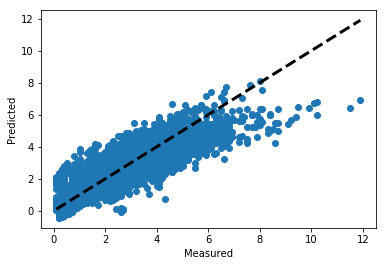

In [48]:
fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

##### 从可视化结果可以看出位于y = x直线区域的点较为密集，预计模型的预测准确度较好，现用打分函数得到该模型作用于测试集上的准确度

In [49]:
linreg.score(X_test, y_test)

0.7824488505845825

##### 后来发现，将测试集的比例test_size适当增大后，准确度有提升，但是不明显。

### 二、对BLE_RSSI数据集的分类

#### 1、决策树 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

##### 读入数据

In [4]:
data = pd.read_csv('Labeled.csv')
data.head(3)

,location,date,b3001,b3002,b3003,b3004,b3005,b3006,b3007,b3008,b3009,b3010,b3011,b3012,b3013
0,O02,10-18-2016 11:15:21,-200,-200,-200,-200,-200,-78,-200,-200,-200,-200,-200,-200,-200
1,P01,10-18-2016 11:15:19,-200,-200,-200,-200,-200,-78,-200,-200,-200,-200,-200,-200,-200
2,P01,10-18-2016 11:15:17,-200,-200,-200,-200,-200,-77,-200,-200,-200,-200,-200,-200,-200


##### 由于date也是一个特征，但是无法对标准时间格式直接进行处理，因此这里考虑将date序列化为时间戳
##### 可以看到标准时间格式的序列被转化成了一个整形序列，然后再对这个数据集进行处理
##### 将数据集后14列切分为特征值矩阵，记为X；
##### 将第一列提取为标签列向量，记为y；

In [5]:
import time
data.describe()
for i in range(len(data['date'])):
    dt = data.loc[i,'date']
    timeArray = time.strptime(dt, "%m-%d-%Y %H:%M:%S")#Y 必须大写
    #转换成时间戳
    timestamp = time.mktime(timeArray)
    data.loc[i,'date']=timestamp
X = data.drop('location', axis=1)#X为包含14个特征值的矩阵
y = data.location
print(X.head(2))
print(y.head(2))

         date  b3001  b3002  b3003  b3004  b3005  b3006  b3007  b3008  b3009  \
0  1476760521   -200   -200   -200   -200   -200    -78   -200   -200   -200   
1  1476760519   -200   -200   -200   -200   -200    -78   -200   -200   -200   

   b3010  b3011  b3012  b3013  
0   -200   -200   -200   -200  
1   -200   -200   -200   -200  
0    O02
1    P01
Name: location, dtype: object


##### 如同前例，将X、y划分为训练集与测试集合

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1)

##### 从sklearn中导入决策树模块，基于特征矩阵和标签向量的训练集构建决策树模型。
##### 此处先将决策树高度设置为3，可以导出树状图，可以看出觉得树是通过值的范围来划分数据的。
##### 但是通过更改决策树的树高发现，树高对预测精度的影响很大，如此处将决策树高度置为3时，测试准度只有5%，
##### 但将树高调整为100后，精度达到了41.12%。

0.05070422535211268


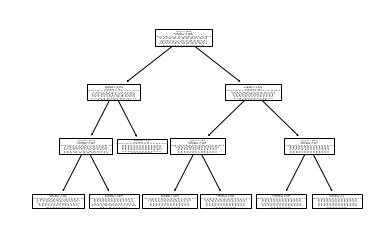

In [8]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=3)#设置高度为3
clf = clf.fit(X_train, y_train)#生成决策树
tree = tree.plot_tree(clf)
print(clf.score(X_test, y_test))

In [11]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=100)#更新高度为100
clf = clf.fit(X_train, y_train)#生成决策树
clf.score(X_test, y_test)

0.4140845070422535

#### 2、支持向量机 

#### 同样直接导入sklearn中的svm库
#### 生成分类器clf

In [12]:
from sklearn import svm
clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

##### 得到支持向量
##### 即距离超平面最近的向量,支撑着分界面

In [15]:
clf.support_vectors_

array([[ 1.47675870e+09, -2.00000000e+02, -2.00000000e+02, ...,
        -2.00000000e+02, -2.00000000e+02, -2.00000000e+02],
       [ 1.47425789e+09, -2.00000000e+02, -2.00000000e+02, ...,
        -2.00000000e+02, -2.00000000e+02, -2.00000000e+02],
       [ 1.47425789e+09, -2.00000000e+02, -2.00000000e+02, ...,
        -2.00000000e+02, -2.00000000e+02, -2.00000000e+02],
       ...,
       [ 1.47675927e+09, -2.00000000e+02, -2.00000000e+02, ...,
        -2.00000000e+02, -1.99000000e+02, -6.70000000e+01],
       [ 1.46907444e+09, -2.00000000e+02, -2.00000000e+02, ...,
        -2.00000000e+02, -2.00000000e+02, -7.50000000e+01],
       [ 1.47554939e+09, -2.00000000e+02, -2.00000000e+02, ...,
        -2.00000000e+02, -2.00000000e+02, -5.90000000e+01]])

##### 用测试集预测准确度

In [16]:
clf.score(X_test, y_test)

0.02535211267605634

###### 3、随机森林

#### 同样直接导入sklearn中的RandomForestClassifier库
#### 生成分类器clf

In [18]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)

###### 用测试集预测准确度
###### 可以发现随机森林和决策树对该数据集的分类效果较好，而支持向量机的分类效果不太优秀

In [19]:
#用测试集预测准确度
clf.score(X_test, y_test)

0.4056338028169014

### 二、对BLE_RSSI数据集的分类

##### 1、Kmeans
##### 首先导入必要的处理包，以及从sklearn中导入KMeans库，以及可视化需要的TSNE库

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

##### 读取不含标签的数据集，存入data变量中，等待聚类。
##### 由于在聚类算法中，不需要训练过程，因此将数据集的第一列直接剔除，后十四列作为特征矩阵。

In [22]:
data = pd.read_csv('Unlabeled.csv')
import time
data.describe()
for i in range(len(data['date'])):
    dt = data.loc[i,'date']
    timeArray = time.strptime(dt, "%m-%d-%Y %H:%M:%S")
    #转换成时间戳
    timestamp = time.mktime(timeArray)
    data.loc[i,'date']=timestamp
X = data.drop('location', axis=1)#X为包含14个特征值的矩阵

#####  构建Kmeans模型

In [23]:
scale = MinMaxScaler().fit(X) 
X_dataScale = scale.transform(X)
kmeans = KMeans(n_clusters=3,random_state=123).fit(X_dataScale)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

##### 用TSNE将数据降为三维，将聚类结果进行可视化
##### 不幸的是，三类点较为分散，聚类效果不能说较好。

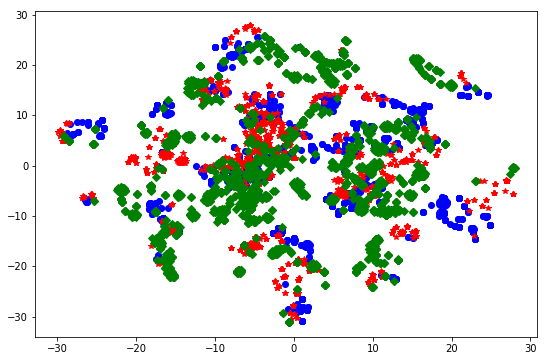

In [24]:
tsne = TSNE(n_components=3,init='random',random_state=100).fit(X) 
data = pd.DataFrame(tsne.embedding_)# 将原始数据转换为DataFrame
data['labels'] = kmeans.labels_  # 将聚类结果存储进data数据表中
data1 = data[data['labels']==0]
data2 = data[data['labels']==1]
data3 = data[data['labels']==2]
fig = plt.figure(figsize=(9,6)) # 绘制图形  设定空白画布，并制定大小
plt.plot(data1[0],data1[1],'bo',data2[0],data2[1],'r*',data3[0],data3[1],'gD')
plt.show()                  

##### 2、DBScan
##### 首先导入必要的处理包，以及从sklearn中导入DBSCAN库，以及可视化需要的TSNE库

In [41]:
from sklearn import datasets  
import pandas  as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
data = pd.read_csv('Unlabeled.csv')
data = pd.read_csv('Unlabeled.csv')
#把时间转化成时间戳
import time
data.describe()
for i in range(len(data['date'])):
    dt = data.loc[i,'date']
    timeArray = time.strptime(dt, "%m-%d-%Y %H:%M:%S")
    #转换成时间戳
    timestamp = time.mktime(timeArray)
    data.loc[i,'date']=timestamp
X = data.drop('location', axis=1)#X为包含14个特征值的矩阵
type(X)

pandas.core.frame.DataFrame

##### 将数据集从DataFrame格式转化为np.array格式，方便后续处理

In [42]:
X=X.values

##### 构造聚类器，其中一个参数是聚类半径，一个是聚类密度；
##### 然后从聚类器中获取簇(community)数，并提取标签，方便后续可视化；
##### 最后获取噪点数，作为参考。

In [43]:
dbscan = DBSCAN(eps=0.5,min_samples=3).fit(X)#构造聚类器,一个参数是半径，一个是密度
labels = dbscan.labels_ #获取聚类标签
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)#获取聚类所得簇数
n_noise_ = list(labels).count(-1)#获取噪点数
dbscan

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=3, n_jobs=None, p=None)

##### 用TSNE将数据降为三维，将聚类结果进行可视化
##### 可以看出，其中一类点聚集于四个不同的位置，其余两类不能清除地观察到
##### 聚类效果不能说较好。

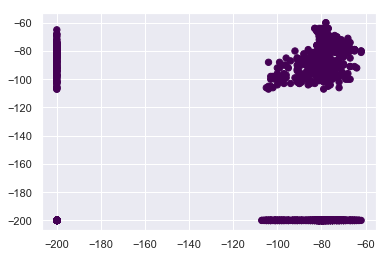

In [44]:
tsne = TSNE(n_components=3,init='random',random_state=100).fit(X)
labels = dbscan.fit_predict(X)
plt.scatter(X[:, 2], X[:, 3], c=labels, s=40, cmap='viridis');

##### 3、GMM
##### 首先导入必要的处理包，以及从sklearn中导入GaussianMixture库，以及可视化需要的TSNE库
##### 并将数据集从DataFrame格式转化为np.array格式，方便后续处理

In [47]:
from sklearn import datasets  
import pandas  as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
import seaborn as sns; sns.set()
data = pd.read_csv('Unlabeled.csv')
import time
data.describe()
for i in range(len(data['date'])):
    dt = data.loc[i,'date']
    timeArray = time.strptime(dt, "%m-%d-%Y %H:%M:%S")
    #转换成时间戳
    timestamp = time.mktime(timeArray)
    data.loc[i,'date']=timestamp
X = data.drop('location', axis=1)#X为包含14个特征值的矩阵
X=X.values

##### 用TSNE将数据降为三维，将聚类结果进行可视化
##### 可以看出，其中一类点聚集于四个不同的位置，第二类聚集于三个不同的位置
##### 最后一类聚集于右上方
##### 聚类效果显然比DBSCAN好

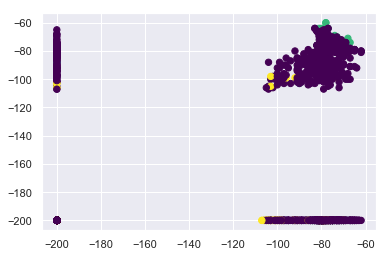

In [49]:
gmm = GaussianMixture(n_components=4).fit(X)
tsne = TSNE(n_components=3,init='random',random_state=100).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 2], X[:, 3], c=labels, s=40, cmap='viridis');

##### 4、层次聚类  
##### 首先导入必要的处理包，以及从sklearn中导入AgglomerativeClustering库，以及可视化需要的TSNE库
##### 并将数据集从DataFrame格式转化为np.array格式，方便后续处理

In [50]:
from sklearn import datasets  
import pandas  as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns; sns.set()
data = pd.read_csv('Unlabeled.csv')
import time
data.describe()
for i in range(len(data['date'])):
    dt = data.loc[i,'date']
    timeArray = time.strptime(dt, "%m-%d-%Y %H:%M:%S")
    #转换成时间戳
    timestamp = time.mktime(timeArray)
    data.loc[i,'date']=timestamp
X = data.drop('location', axis=1)#X为包含14个特征值的矩阵
X=X.values
#type(X)

In [51]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=2, compute_full_tree=True,affinity='euclidean', linkage='complete').fit(X)

##### 用TSNE将数据降为三维，将聚类结果进行可视化
##### 可以看出，其中一类点聚集于四个不同的位置，第二类聚集于右上方位置
##### 第三类不能清晰地观察到
##### 聚类效果也不能说较好，但比GMM效果好一点

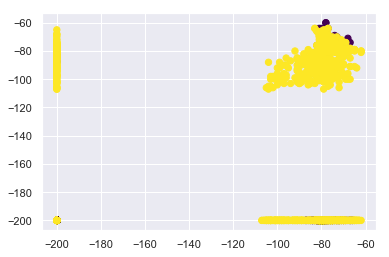

In [52]:
tsne = TSNE(n_components=3,init='random',random_state=100).fit(X)
labels = clustering.fit_predict(X)
plt.scatter(X[:, 2], X[:, 3], c=labels, s=40, cmap='viridis');